### CT5133 Assignment 2: Transfer Learning, Convolutions, and Object Localisation in Keras

Aidan Tynan - 16394923

Luke Hayes - 

#### Import necessary libraries

In [208]:
#!pip install tensorflow
#!pip install keras

In [11]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

# Part 1: Dataset

The dataset chosen for this assignment was sourced from a classification competition created by Professor Hyoseok Hwang for his deep learning class in South Korea. It was created to improve deep learning and pytorch coding skills for students in his class where they were asked to code a classifier using pytorch.

The dataset consists of images of 4 different animals with 900 training and 100 validation images for each animal. The animals in the dataset are: cheetahs, tigers, jaguars and hyenas. As this assignment only required two classes, cheetah and tiger images were chosen as the datasets to be used.

The images have a shape of (400,400,3) with those numbers being height, width and rgb/colour values respectively. These images have to be resized to (224,224,3) for our model implementation to process them. There is a small amount of pre-processing applied to the data which will be discussed in part two.


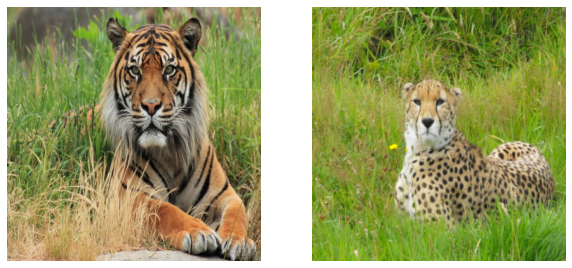

In [211]:
#Plot two example images
for i in range(1):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(Image.open('./validate/tiger_v/tiger_012_val_resized.jpg'))
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(Image.open('./validate/cheetah_v/cheetah_018_val_resized.jpg'))
    plt.axis("off")

## Import Datasets

In [13]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory('./train',image_size=(224,224), seed=42)

Found 1800 files belonging to 2 classes.


In [14]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('./validate',image_size=(224,224),seed=42)

Found 200 files belonging to 2 classes.


## Plot example images with binary labels

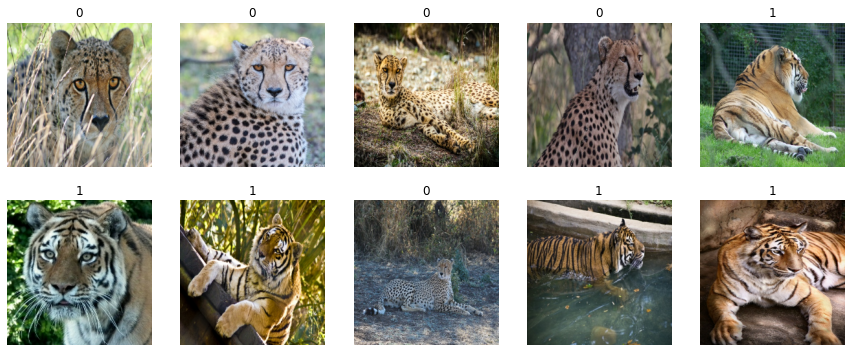

In [149]:
#Plot random example images from the resized dataset and title with their binary label, cheetah:(0), tiger:(1)
for image_demo in training_dataset.take(1):
    plt.figure(figsize=(15,6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(np.array(image_demo[0][i]).astype(int))
        plt.title(int(image_demo[1][i]))
        plt.axis("off")

Link to the dataset: https://www.kaggle.com/iluvchicken/cheetah-jaguar-and-tiger

# Part 2: Transfer Learning

<i> A. Correct use of a pre-trained model for the new task, with appropriate choice of classification head and re-training. Results reported and interpreted.

B. Complete use of a pre-trained model, but with some inappropriate/unmotivated choices. Complete results with some flaws.<i/>

The pre-trained image classification model chosen for this assignment was MobileNetV2/imagenet. <b> SENTENCE HERE ABOUT WHY OR SOMETHING </b>

The dense classification head was removed by setting the include_top variable to false when importing the model.

A pre-processing layer was created to to randomly flip images horizontally and rotate or zoom them slightly. Basic data 
augmentation techniques that have been proven to improve deep learning image classifiers <b>[1].</b>
A Normalization layer was required to normalize the inputs from the pre-processing layer. It normalizes them using the mean and standard deviation to put the values in the range (-1,1). Once the inputs are normalized they are passed to the base layer of the MobileNetV2 model with imagenet weights. A globabl average pooling layer is then added before finally adding a dense layer with two neurons that uses the softmax activation function to predict the two classes.

The model is created below and then trained and evaluated. The base model is frozen so only the added layers will be trained.

## Generate Model

In [21]:
batch_size = 32
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Create a layer to randomly flip images or to rotate/zoom slightly
preprocessing_improvement = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

# Add layers to be trained
inputs = keras.Input(shape=(224, 224, 3))
x = preprocessing_improvement(inputs)  # Apply random data augmentation

#Need to add a normalizing layer to put inputs in the range (-1,1), (from (0,255))
#Without normalizing accuracy ~70% with normalizing its ~95%
#outputs = (inputs - mean) / sqrt(var)
normalization_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3) #255/2
variance = mean * mean
x = normalization_layer(x)
normalization_layer.set_weights([mean, variance])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,553
Trainable params: 2,562
Non-trainable params: 2,257,991
_______________________________________________

## Train Model

The model training can be seen below, the number of epochs can be altered.

In [229]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
epochs = 1
model.fit(training_dataset, epochs=epochs)

57/57 [==============================] - 55s 910ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9203


<b> Needs some comment on the performance / loss </b> 

Generally pretty good after only 1 epoch

#### Save model for later use

In [244]:
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1\assets


#### Load model

In [18]:
model= keras.models.load_model('models/model_1')

## Evaluate Model on validation images

In [19]:
model.evaluate(validation_dataset)

7/7 [==============================] - 10s 597ms/step - loss: 0.0158 - sparse_categorical_accuracy: 0.9950


[0.01583808660507202, 0.9950000047683716]

<b>Comment on the performance of the network on the validation set after pre-processing and normalisation </b>
Need to run multiple times measuring performance when these layers are added/missing

Sneaking suspicion that the model might be telling us its 99.5% accuracte but that not being the case if we were to go by the scores model.predict returns. Not fully sure what this means yet

Need to state and explain the shape of the base models output (think this means the (7x7) heatmap x 1280 channels

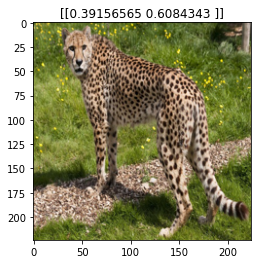

In [246]:
for i in range(1):
    image = np.asarray(Image.open('./validate/cheetah_v/cheetah_001_val_resized.jpg').resize((224,224),3))
    cheetah_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
    title1 = model.predict(cheetah_forPrediction)
    plt.imshow(image)
    plt.title(title1)

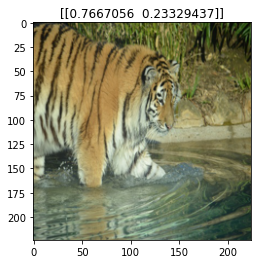

In [253]:
for i in range(1):
    tiger = np.asarray(Image.open('./validate/tiger_v/tiger_007_val_resized.jpg').resize((224,224),3))
    tiger_forPrediction = np.reshape(tiger,(1,tiger.shape[0],tiger.shape[1],tiger.shape[2]))
    title2 = model.predict(tiger_forPrediction)
    plt.imshow(tiger)
    plt.title(title2)

# Part 3 Find interesting neurons/channels

In [207]:
#base_model.summary()

In [22]:
global_pooling = keras.layers.GlobalAveragePooling2D()
#1280 for the number of neurons
softmax_layer = keras.layers.Softmax()

neuronSearch = keras.Sequential(
    [
        base_model,
        global_pooling,
        softmax_layer        
    ]
)
neuronSearch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
softmax_1 (Softmax)          (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [241]:
cheetah_arr = neuronSearch.predict(cheetah_forPrediction)

In [242]:
#Find the maximum value of the softmax output and get the index of it
maxVal = cheetah_arr.max()
index = np.where(cheetah_arr == maxVal)
index
#Examples for cheetah 515, 511, 14

(array([0], dtype=int64), array([14], dtype=int64))

In [23]:
import os
notebook_path = os.path.abspath("DeepLearningAssignment2.ipynb")

In [243]:
#Function to find neurons that are strongly correlated with the class labels
#Probably do this by looping over and predicting images for both classes
#for each prediction find the index of the highest softmax output for the image
#add the index of this "channel" to a list
#Depending on how many images are considered, see if any nodes were correlated frequently and use those

In [33]:
#OKAY SO BASICALLY HERE WE WANT TO CREATE A FUNCTION THAT 
#TAKES IN AN IMAGE OR SET OF IMAGES
#USING THE SOFTMAX LAYER WE WANT TO EXTRACT THE THE TOP 3 NEURONS AND THEN ADD THEM TO A DICTIONARY WITH THE 
#NUMBER OF TIMES THAT NEURON HAS SHOWED AS BEING IMPORTANT FOR ALL THE IMAGES
#THEN WE WILL SELECT THE TOP N AS THE MOST IMPORTANT 
def interesting_neurons(animal, N):
    
    #FILE PATH WE WILL USE WILL DEPEND ON THE ANIMAL 
    if animal == "cheetah":
        path = './train/cheetah/'
    elif animal == "tiger":
        path = './train/tiger/'

    #CREATE A BLANK DICTIONARY SO WE CAN ADD THE NEURON AND THE NUMBER OF TIMES IT HAS APPEARED
    neuron_dict = {}
    
    for filename in os.listdir(path):
        #print(filename)
        image = np.asarray(Image.open(path + filename).resize((224,224),3))
        img_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
        img_array = neuronSearch.predict(img_forPrediction)
        neurons = sorted(range(len(img_array[0])), key = lambda sub: img_array[0][sub])[-N:]
        #print(neurons)
        
        #NOW LOOP THROUGH THE RESULTS AND APPEND TO THE DICTIONARY 
        #ADD IF NEW OR INCREMENT IF NOT NEW 
        
        for neur in neurons:
            if neur in neuron_dict:
                neuron_dict[neur] += 1
                #print("incrementing")
            else:
                neuron_dict[neur] = 1
                #print("adding")
    return neuron_dict
        
#GET THE INTERESTING       
cheetah_dict = interesting_neurons("cheetah", 3)       
tiger_dict = interesting_neurons("tiger", 3)

#NOW LETS GET THE TOP 5 OF EACH 
cheetah_keys = sorted(cheetah_dict, key=cheetah_dict.get, reverse=True)[:5]
tiger_keys = sorted(tiger_dict, key=tiger_dict.get, reverse=True)[:5]


print(cheetah_keys)
print(tiger_keys)


[522, 1241, 587, 511, 90]
[522, 1241, 587, 511, 54]


In [120]:
#cheetah_dict 
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 854), (1241: 514), (587: 191), (511: 176), (90: 163)
# ~95%, 57%, 21%, 19.5%, 18%

#tiger_dict
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 843), (1241: 429), (587: 423), (511: 275), (54: 237)

# Part 4: Object Localization

In [57]:
#using interesting channels obtained from part 3 (Examples for cheetah 515, 511, 14)
#visualize 2d output
#comment on if it coould allow localisation of objects in the input image.
#several examples and corresponding 2d outputs.
base_model.layers[153].output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

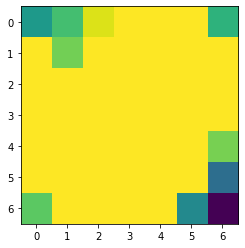

In [124]:
last_layer = len(base_model.layers) - 1

prediction_tensor = base_model.predict(tiger_forPrediction)
prediction_tensor
plt.imshow(prediction_tensor[0,:,:,511])

<b>[1]</b>  Shorten, C., Khoshgoftaar, T.M. A survey on Image Data Augmentation for Deep Learning. J Big Data 6, 60 (2019). 
https://doi.org/10.1186/s40537-019-0197-0